In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
from datetime import datetime, timedelta

def generate_date_array(start_date, length):
    date_array = []
    current_date = start_date

    while len(date_array) < length:
        if current_date.weekday() < 5:  # Check if it's a weekday
            date_array.append(current_date)
        current_date += timedelta(days=1)  # Move to the next day

    return date_array

In [3]:
_split = 0.8
epochs = 200
batch_size = 64
time_step = 60

## VCB

In [4]:
# Load the stock data
data_path = '../../Dataset/VCB.csv'
data = pd.read_csv(data_path) 
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data = data[['Close']]

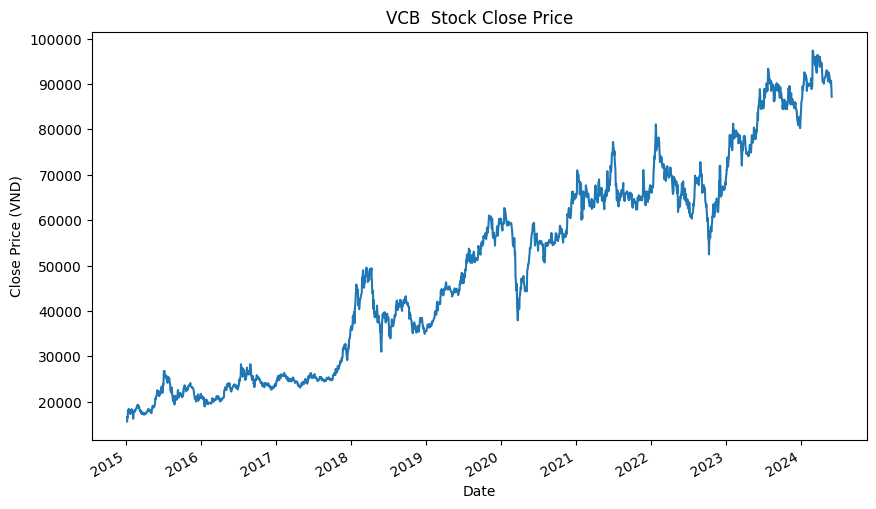

In [5]:
# Plot the data
plt.figure(figsize=(10, 6))
data['Close'].plot()
plt.title("VCB  Stock Close Price")
plt.xlabel('Date')
plt.ylabel('Close Price (VND)')
plt.show()

In [6]:
# Scale the data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)
dataset = pd.DataFrame(data_scaled, columns=['Close'])
dataset.set_index(data.index, inplace=True)

<Axes: xlabel='Date'>

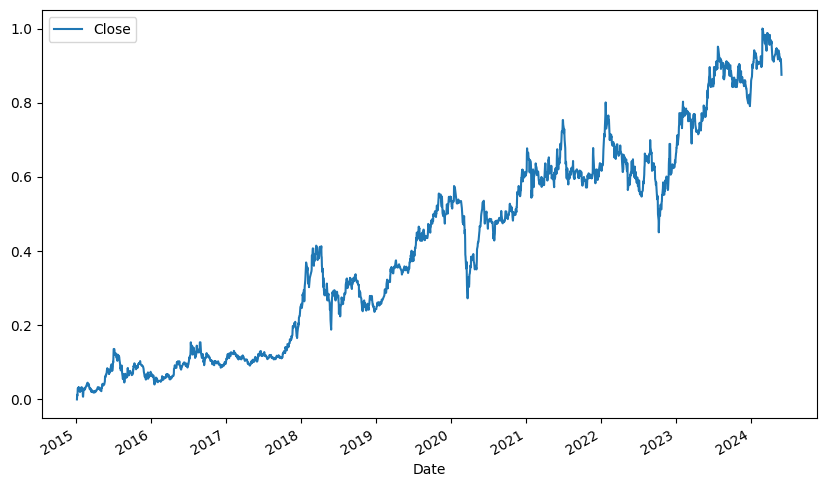

In [7]:
dataset.plot(figsize=(10, 6))

In [8]:
train_size = int(len(dataset) * _split)
test_size = len(dataset) - train_size

train_data = data[:train_size]
test_data = data[train_size:]

train_size, test_size

(1871, 468)

In [9]:
train_data_scaled = dataset[:train_size]
test_data_scaled = dataset[train_size:]

In [10]:
def create_data_for_RNN(data, time_step=60):
    X, y = [], []
    for i in range(0, len(data)):
        if(i-time_step >= 0):
            X.append(data[i-time_step:i])
            y.append(data[i])
        else:
            X.append(np.zeros(time_step))
            y.append(data[i])
    return np.array(X), np.array(y)

In [11]:
X, y = create_data_for_RNN(dataset['Close'].values, time_step=time_step)

In [12]:
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

In [13]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1871, 60), (1871,), (468, 60), (468,))

In [14]:
# Reshape the data for RNN input
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [15]:
print(f"X_train Shape: {X_train.shape}, y_train Shape: {y_train.shape}")
print(f"X_test Shape: {X_test.shape}, y_test Shape: {y_test.shape}")

X_train Shape: (1871, 60, 1), y_train Shape: (1871,)
X_test Shape: (468, 60, 1), y_test Shape: (468,)


In [16]:
# Build the RNN model
model = Sequential()
model.add(SimpleRNN(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(SimpleRNN(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

c:\Users\vanma\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [17]:
# Train the model
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test))

Epoch 1/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 0.0948 - val_loss: 0.0142
Epoch 2/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 8.9894e-04 - val_loss: 0.0037
Epoch 3/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3.7986e-04 - val_loss: 0.0031
Epoch 4/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3.9465e-04 - val_loss: 0.0024
Epoch 5/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3.4124e-04 - val_loss: 0.0022
Epoch 6/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3.7892e-04 - val_loss: 0.0016
Epoch 7/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3.2880e-04 - val_loss: 0.0022
Epoch 8/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.8123e-04 - val_loss: 0.0014
Epoch 9/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.2028e-04 - val_loss: 0.0011
Epoch 10/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.0375e-04 - val_loss: 0.0020
Epoch 11/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.2253e-04 - val_loss: 0.0010
Epoch 12/200

In [18]:
# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [19]:
# Inverse transform predictions
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

In [20]:
# Calculate accuracy metrics
train_rmse = np.sqrt(mean_squared_error(y_train, train_predict))
train_mae = mean_absolute_error(y_train, train_predict)
train_mape = np.mean(np.abs((y_train - train_predict) / y_train)) * 100

test_rmse = np.sqrt(mean_squared_error(y_test, test_predict))
test_mae = mean_absolute_error(y_test, test_predict)
test_mape = np.mean(np.abs((y_test - test_predict) / y_test)) * 100

# Round the metrics to three decimal places
train_rmse = round(train_rmse, 3)
train_mae = round(train_mae, 3)
train_mape = round(train_mape, 3)

test_rmse = round(test_rmse, 3)
test_mae = round(test_mae, 3)
test_mape = round(test_mape, 3)

print(f"Train RMSE: {train_rmse}, Train MAE: {train_mae}, Train MAPE: {train_mape}%")
print(f"Test RMSE: {test_rmse}, Test MAE: {test_mae}, Test MAPE: {test_mape}%")

Train RMSE: 1154.126, Train MAE: 921.082, Train MAPE: 2.343%
Test RMSE: 2835.221, Test MAE: 2312.088, Test MAPE: 2.776%


In [21]:
def predict_future_prices(days):
    future_prices = []
    X = []
    for i in range(0, time_step):        
        X = test_data_scaled['Close'].values[i-time_step:]
        if(i > 0):
            X = np.append(X, future_prices[:i])
        pred = model.predict(X.reshape(1, time_step, 1))
        future_prices.append(pred[0][0])
        X = []
    for i in range(0, days-time_step):
        X = np.array(future_prices[i:i+time_step])
        pred = model.predict(X.reshape(1, time_step, 1))
        future_prices.append(pred[0][0])
        X = []
    return np.array(future_prices)


In [22]:
future_days = 90
future_dates = generate_date_array(data.index[-1] + timedelta(days=1), future_days)
future_prices = predict_future_prices(future_days)
future_prices = scaler.inverse_transform(future_prices.reshape(-1, 1))
future_data = pd.DataFrame(future_prices, columns=['Close'], index=future_dates)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━

In [23]:
predict_30_days = future_data[:30]
predict_60_days = future_data[:60]
predict_90_days = future_data[:90]

In [24]:
test_predict = test_predict.reshape(-1)
test_predict = pd.DataFrame(test_predict, columns=['Close'], index=test_data.index)

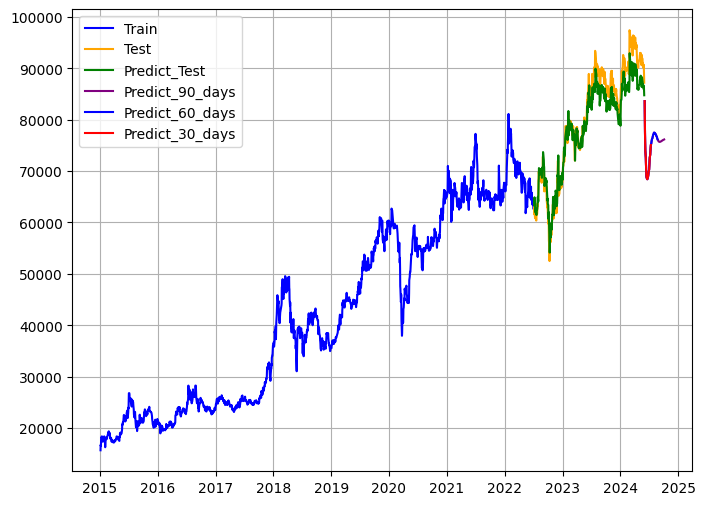

In [25]:
plt.figure(figsize=(8, 6))
plt.plot(train_data.index, train_data['Close'], label='Train', color='blue')
plt.plot(test_data.index, test_data['Close'], label='Test', color='orange')
plt.plot(test_predict.index, test_predict['Close'], label='Predict_Test', color='green')
plt.plot(predict_90_days.index, predict_90_days['Close'], label='Predict_90_days', color='purple')
plt.plot(predict_60_days.index, predict_60_days['Close'], label='Predict_60_days', color='blue')
plt.plot(predict_30_days.index, predict_30_days['Close'], label='Predict_30_days', color='red')
plt.grid(True)
plt.legend()
plt.show()

## BID

In [26]:
# Load the stock data
data_path = '../../Dataset/BID.csv'
data = pd.read_csv(data_path) 
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data = data[['Close']]

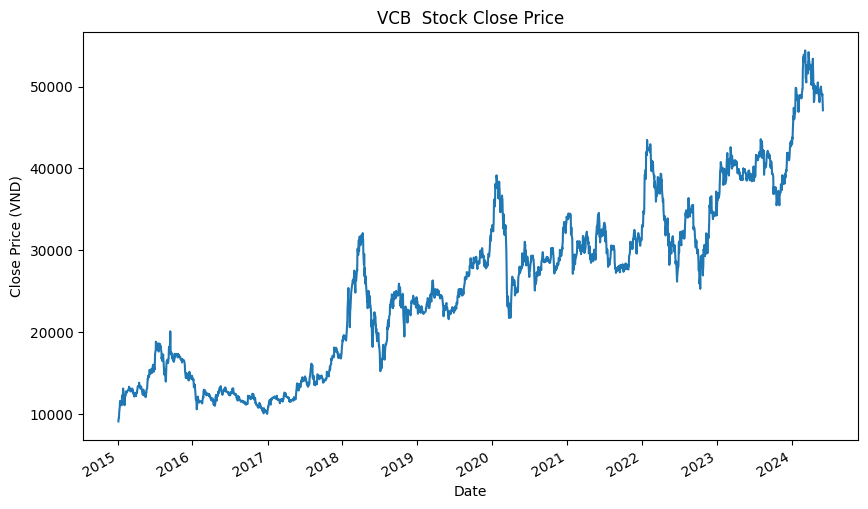

In [27]:
# Plot the data
plt.figure(figsize=(10, 6))
data['Close'].plot()
plt.title("VCB  Stock Close Price")
plt.xlabel('Date')
plt.ylabel('Close Price (VND)')
plt.show()

In [28]:
# Scale the data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)
dataset = pd.DataFrame(data_scaled, columns=['Close'])
dataset.set_index(data.index, inplace=True)

<Axes: xlabel='Date'>

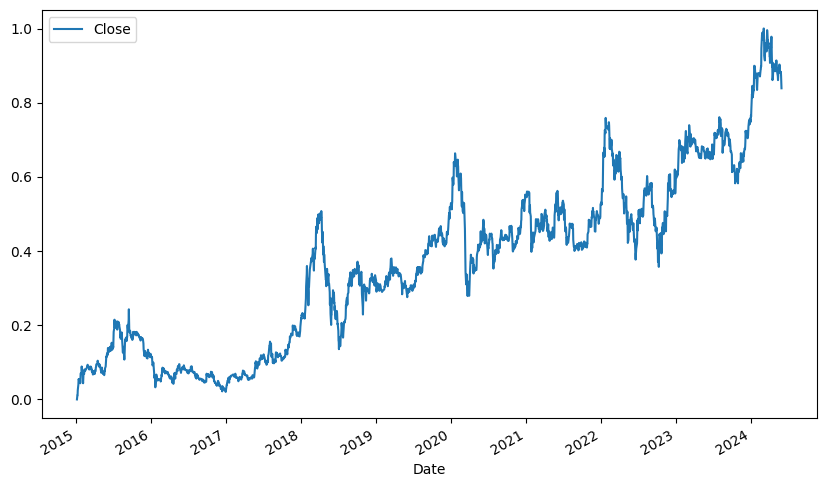

In [29]:
dataset.plot(figsize=(10, 6))

In [30]:
train_size = int(len(dataset) * _split)
test_size = len(dataset) - train_size

train_data = data[:train_size]
test_data = data[train_size:]

train_size, test_size

(1876, 469)

In [31]:
train_data_scaled = dataset[:train_size]
test_data_scaled = dataset[train_size:]

In [32]:
def create_data_for_RNN(data, time_step=60):
    X, y = [], []
    for i in range(0, len(data)):
        if(i-time_step >= 0):
            X.append(data[i-time_step:i])
            y.append(data[i])
        else:
            X.append(np.zeros(time_step))
            y.append(data[i])
    return np.array(X), np.array(y)

In [33]:
X, y = create_data_for_RNN(dataset['Close'].values, time_step=time_step)

In [34]:
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

In [35]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1876, 60), (1876,), (469, 60), (469,))

In [36]:
# Reshape the data for RNN input
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [37]:
print(f"X_train Shape: {X_train.shape}, y_train Shape: {y_train.shape}")
print(f"X_test Shape: {X_test.shape}, y_test Shape: {y_test.shape}")

X_train Shape: (1876, 60, 1), y_train Shape: (1876,)
X_test Shape: (469, 60, 1), y_test Shape: (469,)


In [38]:
# Build the RNN model
model = Sequential()
model.add(SimpleRNN(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(SimpleRNN(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

c:\Users\vanma\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [39]:
# Train the model
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test))

Epoch 1/200


30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.5591 - val_loss: 0.0524
Epoch 2/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0075 - val_loss: 0.0058
Epoch 3/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0016 - val_loss: 0.0044
Epoch 4/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0012 - val_loss: 0.0033
Epoch 5/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0011 - val_loss: 0.0031
Epoch 6/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 9.2104e-04 - val_loss: 0.0027
Epoch 7/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 8.1972e-04 - val_loss: 0.0020
Epoch 8/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 7.3290e-04 - val_loss: 0.0014
Epoch 9/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 6.4803e-04 - val_loss: 0.0018
Epoch 10/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 6.6808e-04 - val_loss: 0.0011
Epoch 11/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 5.7105e-04 - val_loss: 0.0010
Epoch 12/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 

In [40]:
# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [41]:
# Inverse transform predictions
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

In [42]:
# Calculate accuracy metrics
train_rmse = np.sqrt(mean_squared_error(y_train, train_predict))
train_mae = mean_absolute_error(y_train, train_predict)
train_mape = np.mean(np.abs((y_train - train_predict) / y_train)) * 100

test_rmse = np.sqrt(mean_squared_error(y_test, test_predict))
test_mae = mean_absolute_error(y_test, test_predict)
test_mape = np.mean(np.abs((y_test - test_predict) / y_test)) * 100

# Round the metrics to three decimal places
train_rmse = round(train_rmse, 3)
train_mae = round(train_mae, 3)
train_mape = round(train_mape, 3)

test_rmse = round(test_rmse, 3)
test_mae = round(test_mae, 3)
test_mape = round(test_mape, 3)

print(f"Train RMSE: {train_rmse}, Train MAE: {train_mae}, Train MAPE: {train_mape}%")
print(f"Test RMSE: {test_rmse}, Test MAE: {test_mae}, Test MAPE: {test_mape}%")

Train RMSE: 598.193, Train MAE: 423.234, Train MAPE: 2.032%
Test RMSE: 827.201, Test MAE: 601.537, Test MAPE: 1.54%


In [43]:
def predict_future_prices(days):
    future_prices = []
    X = []
    for i in range(0, time_step):        
        X = test_data_scaled['Close'].values[i-time_step:]
        if(i > 0):
            X = np.append(X, future_prices[:i])
        pred = model.predict(X.reshape(1, time_step, 1))
        future_prices.append(pred[0][0])
        X = []
    for i in range(0, days-time_step):
        X = np.array(future_prices[i:i+time_step])
        pred = model.predict(X.reshape(1, time_step, 1))
        future_prices.append(pred[0][0])
        X = []
    return np.array(future_prices)


In [44]:
future_days = 90
future_dates = generate_date_array(data.index[-1] + timedelta(days=1), future_days)
future_prices = predict_future_prices(future_days)
future_prices = scaler.inverse_transform(future_prices.reshape(-1, 1))
future_data = pd.DataFrame(future_prices, columns=['Close'], index=future_dates)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━

In [45]:
predict_30_days = future_data[:30]
predict_60_days = future_data[:60]
predict_90_days = future_data[:90]

In [46]:
test_predict = test_predict.reshape(-1)
test_predict = pd.DataFrame(test_predict, columns=['Close'], index=test_data.index)

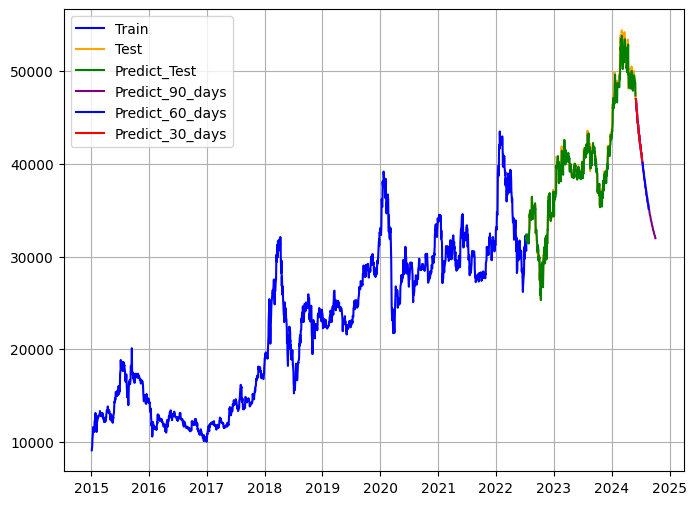

In [47]:
plt.figure(figsize=(8, 6))
plt.plot(train_data.index, train_data['Close'], label='Train', color='blue')
plt.plot(test_data.index, test_data['Close'], label='Test', color='orange')
plt.plot(test_predict.index, test_predict['Close'], label='Predict_Test', color='green')
plt.plot(predict_90_days.index, predict_90_days['Close'], label='Predict_90_days', color='purple')
plt.plot(predict_60_days.index, predict_60_days['Close'], label='Predict_60_days', color='blue')
plt.plot(predict_30_days.index, predict_30_days['Close'], label='Predict_30_days', color='red')
plt.grid(True)
plt.legend()
plt.show()

## CTG

In [48]:
# Load the stock data
data_path = '../../Dataset/CTG.csv'
data = pd.read_csv(data_path) 
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data = data[['Close']]

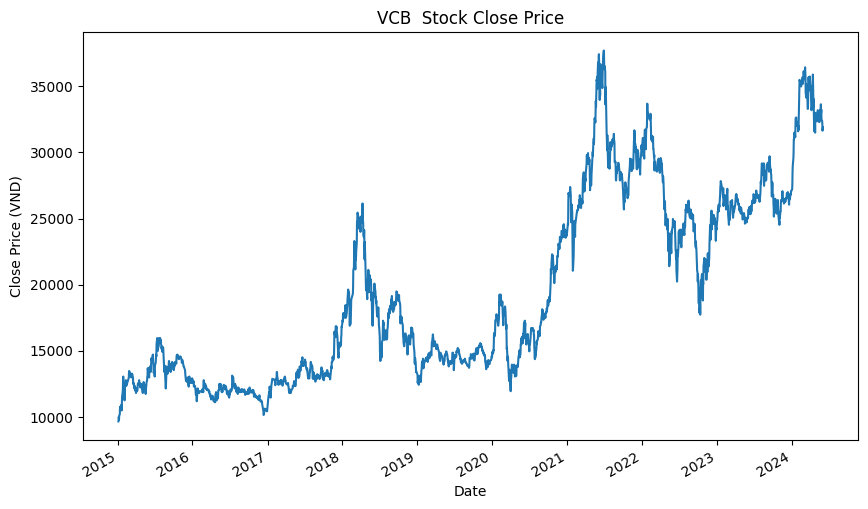

In [49]:
# Plot the data
plt.figure(figsize=(10, 6))
data['Close'].plot()
plt.title("VCB  Stock Close Price")
plt.xlabel('Date')
plt.ylabel('Close Price (VND)')
plt.show()

In [50]:
# Scale the data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)
dataset = pd.DataFrame(data_scaled, columns=['Close'])
dataset.set_index(data.index, inplace=True)

<Axes: xlabel='Date'>

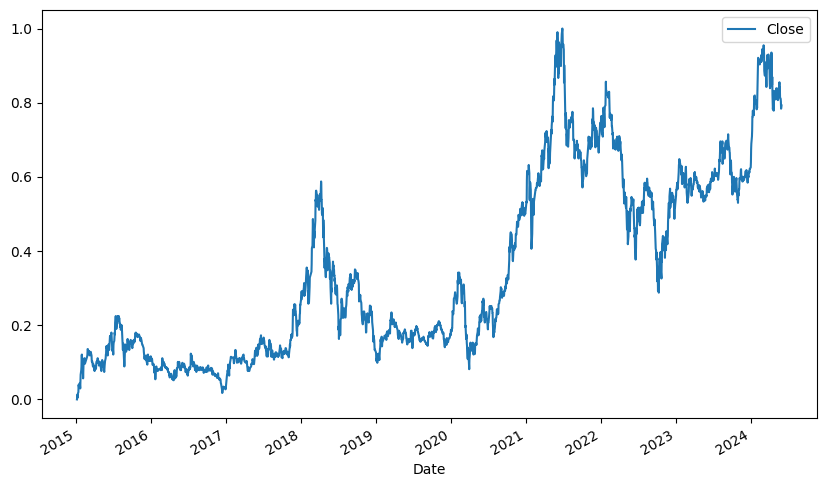

In [51]:
dataset.plot(figsize=(10, 6))

In [52]:
train_size = int(len(dataset) * _split)
test_size = len(dataset) - train_size

train_data = data[:train_size]
test_data = data[train_size:]

train_size, test_size

(1876, 469)

In [53]:
train_data_scaled = dataset[:train_size]
test_data_scaled = dataset[train_size:]

In [54]:
def create_data_for_RNN(data, time_step=60):
    X, y = [], []
    for i in range(0, len(data)):
        if(i-time_step >= 0):
            X.append(data[i-time_step:i])
            y.append(data[i])
        else:
            X.append(np.zeros(time_step))
            y.append(data[i])
    return np.array(X), np.array(y)

In [55]:
X, y = create_data_for_RNN(dataset['Close'].values, time_step=time_step)

In [56]:
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

In [57]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1876, 60), (1876,), (469, 60), (469,))

In [58]:
# Reshape the data for RNN input
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [59]:
print(f"X_train Shape: {X_train.shape}, y_train Shape: {y_train.shape}")
print(f"X_test Shape: {X_test.shape}, y_test Shape: {y_test.shape}")

X_train Shape: (1876, 60, 1), y_train Shape: (1876,)
X_test Shape: (469, 60, 1), y_test Shape: (469,)


In [60]:
# Build the RNN model
model = Sequential()
model.add(SimpleRNN(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(SimpleRNN(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

c:\Users\vanma\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [61]:
# Train the model
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test))

Epoch 1/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0993 - val_loss: 0.0020
Epoch 2/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0021 - val_loss: 8.4665e-04
Epoch 3/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 7.1631e-04 - val_loss: 7.9525e-04
Epoch 4/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.4812e-04 - val_loss: 7.0002e-04
Epoch 5/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.3645e-04 - val_loss: 6.7372e-04
Epoch 6/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.3130e-04 - val_loss: 6.7334e-04
Epoch 7/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.5301e-04 - val_loss: 6.7153e-04
Epoch 8/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.9521e-04 - val_loss: 8.5004e-04
Epoch 9/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.4350e-04 - val_loss: 6.0484e-04
Epoch 10/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.3359e-04 - val_loss: 5.6110e-04
Epoch 11/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.6778e-04 - 

In [62]:
# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [63]:
# Inverse transform predictions
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

In [64]:
# Calculate accuracy metrics
train_rmse = np.sqrt(mean_squared_error(y_train, train_predict))
train_mae = mean_absolute_error(y_train, train_predict)
train_mape = np.mean(np.abs((y_train - train_predict) / y_train)) * 100

test_rmse = np.sqrt(mean_squared_error(y_test, test_predict))
test_mae = mean_absolute_error(y_test, test_predict)
test_mape = np.mean(np.abs((y_test - test_predict) / y_test)) * 100

# Round the metrics to three decimal places
train_rmse = round(train_rmse, 3)
train_mae = round(train_mae, 3)
train_mape = round(train_mape, 3)

test_rmse = round(test_rmse, 3)
test_mae = round(test_mae, 3)
test_mape = round(test_mape, 3)

print(f"Train RMSE: {train_rmse}, Train MAE: {train_mae}, Train MAPE: {train_mape}%")
print(f"Test RMSE: {test_rmse}, Test MAE: {test_mae}, Test MAPE: {test_mape}%")

Train RMSE: 835.235, Train MAE: 656.579, Train MAPE: 3.661%
Test RMSE: 1227.0, Test MAE: 1119.526, Test MAPE: 4.183%


In [65]:
def predict_future_prices(days):
    future_prices = []
    X = []
    for i in range(0, time_step):        
        X = test_data_scaled['Close'].values[i-time_step:]
        if(i > 0):
            X = np.append(X, future_prices[:i])
        pred = model.predict(X.reshape(1, time_step, 1))
        future_prices.append(pred[0][0])
        X = []
    for i in range(0, days-time_step):
        X = np.array(future_prices[i:i+time_step])
        pred = model.predict(X.reshape(1, time_step, 1))
        future_prices.append(pred[0][0])
        X = []
    return np.array(future_prices)


In [66]:
future_days = 90
future_dates = generate_date_array(data.index[-1] + timedelta(days=1), future_days)
future_prices = predict_future_prices(future_days)
future_prices = scaler.inverse_transform(future_prices.reshape(-1, 1))
future_data = pd.DataFrame(future_prices, columns=['Close'], index=future_dates)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━

In [67]:
predict_30_days = future_data[:30]
predict_60_days = future_data[:60]
predict_90_days = future_data[:90]

In [68]:
test_predict = test_predict.reshape(-1)
test_predict = pd.DataFrame(test_predict, columns=['Close'], index=test_data.index)

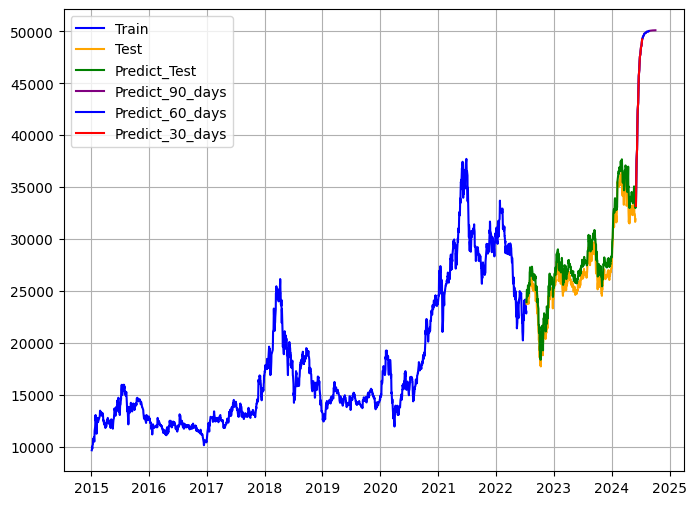

In [69]:
plt.figure(figsize=(8, 6))
plt.plot(train_data.index, train_data['Close'], label='Train', color='blue')
plt.plot(test_data.index, test_data['Close'], label='Test', color='orange')
plt.plot(test_predict.index, test_predict['Close'], label='Predict_Test', color='green')
plt.plot(predict_90_days.index, predict_90_days['Close'], label='Predict_90_days', color='purple')
plt.plot(predict_60_days.index, predict_60_days['Close'], label='Predict_60_days', color='blue')
plt.plot(predict_30_days.index, predict_30_days['Close'], label='Predict_30_days', color='red')
plt.grid(True)
plt.legend()
plt.show()